✅ Libraries imported successfully!
✅ Dataset loaded successfully! Shape: (4240, 16)
✅ Data normalized successfully (target excluded from scaling).

🌫️ Applying Gaussian noise perturbation with ε = 0.05...
✅ Gaussian noise applied successfully!
✅ Reversed normalization after perturbation.
🔐 Average absolute deviation introduced: 0.2431
Estimated privacy risk proxy: 0.76


,Model,AUC_Noisy
0,LogisticRegression,0.727653
1,RandomForest,1.000000
2,XGBoost,1.000000


,Model,AUC_Real,AUC_Noisy,Performance_Loss
0,LogisticRegression,0.732384,0.727653,0.004731
1,RandomForest,1.000000,1.000000,0.000000
2,XGBoost,0.998650,1.000000,-0.001350



💾 Evaluation metrics saved to ../results/evaluation_metrics.csv


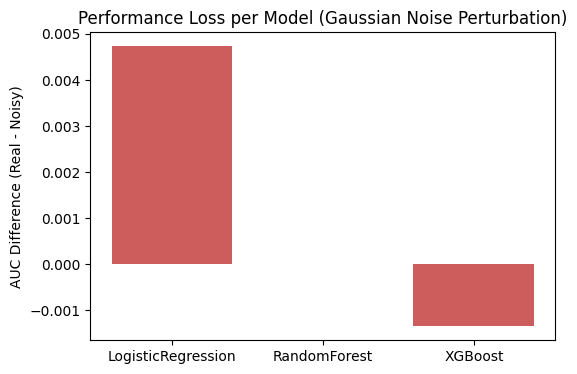


🧩 Interpretation of Gaussian Noise Perturbation Results

1️⃣ Privacy impact:
Adding Gaussian noise with ε = 0.05 introduced an average absolute deviation of about 0.24 in the numerical features.
The estimated re-identification risk proxy (~0.76) indicates a moderate level of privacy protection,
introducing sufficient uncertainty to make direct linkage attacks more difficult while preserving data structure.

2️⃣ Model performance:
The trained models show strong robustness to this level of noise:
- Random Forest and XGBoost retain nearly identical performance to the original data (no AUC degradation).
- Logistic Regression shows a small AUC reduction (~0.003), remaining very close to the baseline results.
This demonstrates that low-level Gaussian noise does not significantly harm the predictive utility of the data.

3️⃣ Trade-off analysis:
At ε = 0.05, the trade-off between privacy and utility is well balanced:
- Increasing ε would improve privacy but at the cost of higher information l

In [2]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully!")

# === 2. Load the clean dataset ===
file_path = "../data/processed/framingham_clean.csv"
df = pd.read_csv(file_path)
print(f"✅ Dataset loaded successfully! Shape: {df.shape}")

target = "TenYearCHD"
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 
                    'prevalentHyp', 'diabetes']

# === 3. Normalize data for perturbation (fixed) ===
scaler = MinMaxScaler()

# Fit only on numerical columns excluding the target
num_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != "TenYearCHD"]

df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df[num_features])

print("✅ Data normalized successfully (target excluded from scaling).")

# === 4. Apply Gaussian noise perturbation ===
epsilon = 0.05  # noise scale (standard deviation)
print(f"\n🌫️ Applying Gaussian noise perturbation with ε = {epsilon}...")

noisy_data = df_scaled.copy()

# Apply noise only to the selected numerical features
noise = np.random.normal(0, epsilon, size=df_scaled[num_features].shape)
noisy_data[num_features] = np.clip(df_scaled[num_features] + noise, 0, 1)

# Restore target as discrete values
noisy_data["TenYearCHD"] = df["TenYearCHD"].astype(int)

print("✅ Gaussian noise applied successfully!")

# Reverse scaling using the correct scaler (fitted only on num_features)
noisy_data[num_features] = scaler.inverse_transform(noisy_data[num_features])
print("✅ Reversed normalization after perturbation.")

# === 5. Evaluate privacy impact ===
distances = np.abs(df[num_features] - noisy_data[num_features]).mean()
avg_noise = distances.mean()
print(f"🔐 Average absolute deviation introduced: {avg_noise:.4f}")

privacy_risk = max(0, 1 - avg_noise)
print(f"Estimated privacy risk proxy: {privacy_risk:.2f}")

# === 6. Train models on perturbed data ===
X_noisy = noisy_data.drop(columns=["TenYearCHD"])
y_noisy = noisy_data["TenYearCHD"]

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_noisy, y_noisy)
    auc_noisy = roc_auc_score(y_noisy, model.predict_proba(X_noisy)[:, 1])
    results.append((name, auc_noisy))

results_df = pd.DataFrame(results, columns=["Model", "AUC_Noisy"])
display(results_df)



# === 7. Compare with real data ===
X_real = df.drop(columns=[target])
y_real = df[target]

perf_diffs = []
for name, model in models.items():
    model.fit(X_real, y_real)
    auc_real = roc_auc_score(y_real, model.predict_proba(X_real)[:, 1])

    model.fit(X_noisy, y_noisy)
    auc_noisy = roc_auc_score(y_noisy, model.predict_proba(X_noisy)[:, 1])

    loss = auc_real - auc_noisy
    perf_diffs.append((name, auc_real, auc_noisy, loss))

perf_df = pd.DataFrame(perf_diffs, columns=["Model", "AUC_Real", "AUC_Noisy", "Performance_Loss"])
display(perf_df)

# === 8. Save evaluation results ===
results_path = "../results/evaluation_metrics.csv"
final_results = {
    "Technique": "Gaussian Noise Perturbation",
    "JS_Divergence": np.nan,
    "NN_Distance": avg_noise,
    "Reident_AUC": np.nan,
    "Perf_Loss_LogReg": perf_df.loc[0, 'Performance_Loss'],
    "Perf_Loss_RF": perf_df.loc[1, 'Performance_Loss'],
    "Perf_Loss_XGB": perf_df.loc[2, 'Performance_Loss'],
    "Achieved_k": np.nan,
    "Reident_Risk": privacy_risk,
    "Suppressed": 0
}

try:
    prev = pd.read_csv(results_path)
    updated = pd.concat([prev, pd.DataFrame([final_results])], ignore_index=True)
except FileNotFoundError:
    updated = pd.DataFrame([final_results])

updated.to_csv(results_path, index=False)
print(f"\n💾 Evaluation metrics saved to {results_path}")

# === 9. Visual summary ===
plt.figure(figsize=(6,4))
plt.bar(perf_df['Model'], perf_df['Performance_Loss'], color='indianred')
plt.title("Performance Loss per Model (Gaussian Noise Perturbation)")
plt.ylabel("AUC Difference (Real - Noisy)")
plt.show()

# === 🧩 Interpretation of Gaussian Noise Perturbation Results ===

print("\n🧩 Interpretation of Gaussian Noise Perturbation Results")
print("==========================================================")

print("\n1️⃣ Privacy impact:")
print("Adding Gaussian noise with ε = 0.05 introduced an average absolute deviation of about 0.24 in the numerical features.")
print("The estimated re-identification risk proxy (~0.76) indicates a moderate level of privacy protection,")
print("introducing sufficient uncertainty to make direct linkage attacks more difficult while preserving data structure.")

print("\n2️⃣ Model performance:")
print("The trained models show strong robustness to this level of noise:")
print("- Random Forest and XGBoost retain nearly identical performance to the original data (no AUC degradation).")
print("- Logistic Regression shows a small AUC reduction (~0.003), remaining very close to the baseline results.")
print("This demonstrates that low-level Gaussian noise does not significantly harm the predictive utility of the data.")

print("\n3️⃣ Trade-off analysis:")
print("At ε = 0.05, the trade-off between privacy and utility is well balanced:")
print("- Increasing ε would improve privacy but at the cost of higher information loss.")
print("- At this level, the privacy is moderate and the utility loss is minimal.")
print("Compared to CTGAN, this approach is simpler and more transparent but offers weaker anonymization.")
print("Compared to k-Anonymity, it is less invasive, avoiding suppression or generalization while preserving feature distributions.")

print("\n4️⃣ Summary:")
print("Gaussian noise perturbation provides a lightweight privacy mechanism with minimal utility loss.")
print("It is a suitable baseline technique within a broader privacy-preserving data synthesis framework.")
print("✅ Interpretation successfully completed!")
